In [13]:

import os
import pickle
import sys
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('..')

from common import *
from datasets.synthetic_aes import SyntheticAES, SyntheticAESLike
from utils.template_attack import TemplateAttack
set_verbosity(True)

In [14]:

base_dirs = [os.path.join(OUTPUT_DIR, f'learning_rate_sweep__ii__{idx}') for idx in range(5)]
with open(os.path.join(base_dirs[0], 'datasets.pickle'), 'rb') as f:
    datasets = pickle.load(f)
train_dataset = datasets['train_dataset']
val_dataset = datasets['val_dataset']
test_dataset = datasets['test_dataset']
profiling_dataset = train_dataset
attack_dataset = test_dataset

In [15]:
results = {'classifier_learning_rates': [], 'obfuscator_learning_rates': [], 'erasure_probs': [], 'training_curves': [], 'template_attack_rots': []}
def get_learning_rates(dirname):
    if not(('clr' in dirname) and ('olr' in dirname)):
        return None
    classifier_lr = float(dirname.split('_')[1])
    obfuscator_lr = float(dirname.split('_')[-1])
    return classifier_lr, obfuscator_lr
result_count = 0
for base_dir in base_dirs:
    result_dirs = os.listdir(base_dir)
    for dirname in tqdm(result_dirs):
        try:
            rv = get_learning_rates(dirname)
            if rv is None:
                continue
            else:
                classifier_lr, obfuscator_lr = rv
            with open(os.path.join(base_dir, dirname, 'trained_erasure_probs.pickle'), 'rb') as f:
                erasure_probs = pickle.load(f)
            with open(os.path.join(base_dir, dirname, 'training_curves.pickle'), 'rb') as f:
                training_curves = pickle.load(f)
            with open(os.path.join(base_dir, dirname, 'ta_rank_over_time.pickle'), 'rb') as f:
                ta_rank_over_time = pickle.load(f)
        except:
            continue
        results['classifier_learning_rates'].append(classifier_lr)
        results['obfuscator_learning_rates'].append(obfuscator_lr)
        results['erasure_probs'].append(erasure_probs)
        results['training_curves'].append(training_curves)
        results['template_attack_rots'].append(ta_rank_over_time)
        result_count += 1

100%|██████████| 7/7 [00:00<00:00, 632.24it/s]
0it [00:00, ?it/s]


In [16]:
classifier_learning_rates = np.unique(results['classifier_learning_rates'])
obfuscator_learning_rates = np.unique(results['obfuscator_learning_rates'])
classifier_learning_rates.sort()
obfuscator_learning_rates.sort()

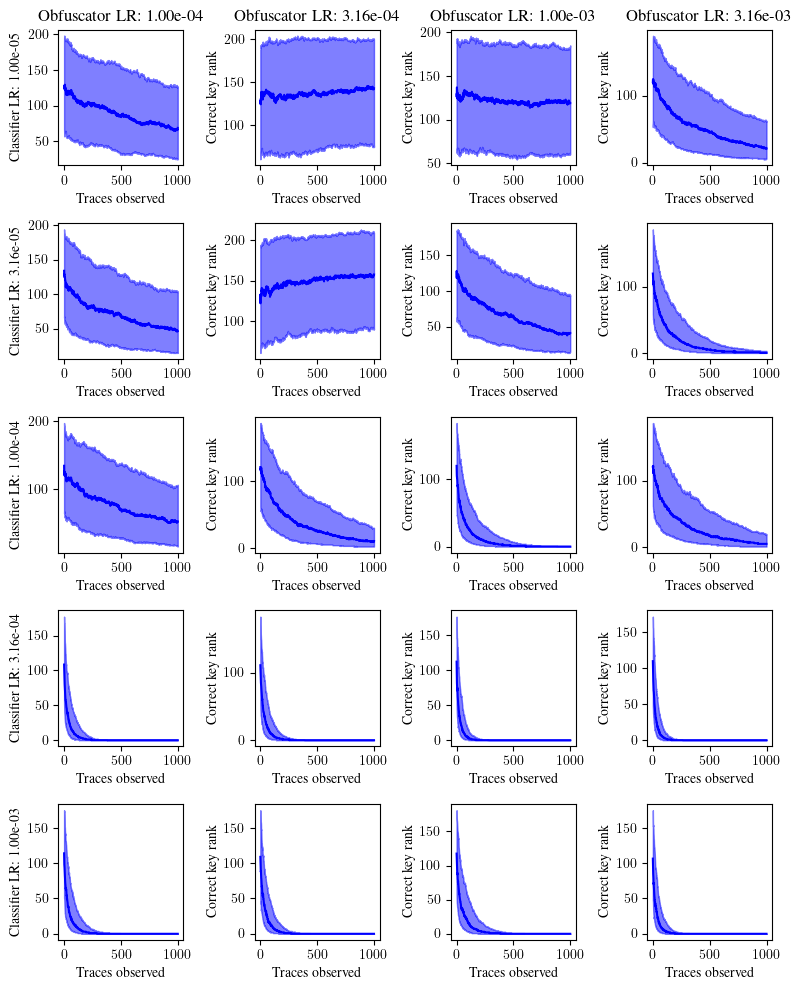

In [17]:

fig, axes = plt.subplots(len(classifier_learning_rates), len(obfuscator_learning_rates), figsize=(2*len(obfuscator_learning_rates), 2*len(classifier_learning_rates)))
for c_idx, classifier_lr in enumerate(classifier_learning_rates):
    for o_idx, obfuscator_lr in enumerate(obfuscator_learning_rates):
        for idx in range(result_count):
            if (results['classifier_learning_rates'][idx] == classifier_lr) and (results['obfuscator_learning_rates'][idx] == obfuscator_lr):
                ax = axes[c_idx, o_idx]
                rot = results['template_attack_rots'][idx]
                median = np.median(rot, axis=0)
                liqr = np.percentile(rot, 25, axis=0)
                uiqr = np.percentile(rot, 75, axis=0)
                ax.plot(median, color='blue')
                ax.fill_between(np.arange(len(median)), liqr, uiqr, color='blue', alpha=0.5)
                ax.set_xlabel('Traces observed')
                ax.set_ylabel('Correct key rank')
for ax, classifier_lr in zip(axes[:, 0], classifier_learning_rates):
    ax.set_ylabel(f'Classifier LR: {classifier_lr:.2e}')
for ax, obfuscator_lr in zip(axes[0, :], obfuscator_learning_rates):
    ax.set_title(f'Obfuscator LR: {obfuscator_lr:.2e}')
fig.tight_layout()

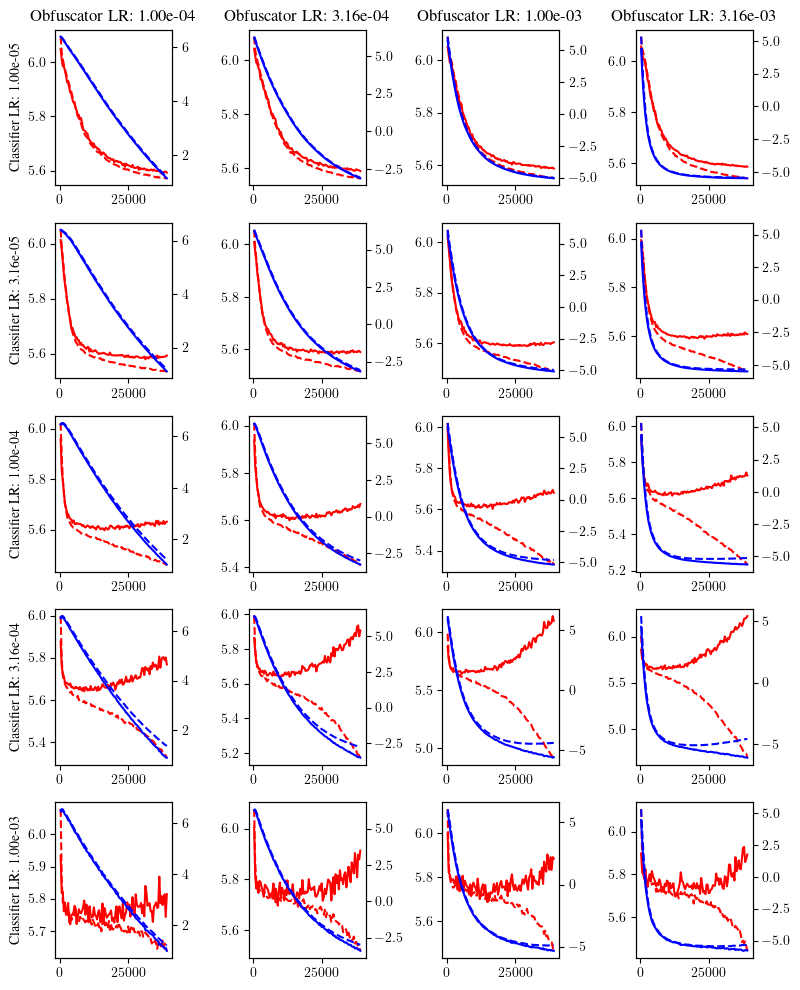

In [18]:
def extract_curve(curve):
    steps = np.array([x.step for x in curve])
    vals = np.array([x.value for x in curve])
    return steps, vals
fig, axes = plt.subplots(len(classifier_learning_rates), len(obfuscator_learning_rates), figsize=(2*len(obfuscator_learning_rates), 2*len(classifier_learning_rates)))
if len(obfuscator_learning_rates) == 1:
    axes = axes[:, np.newaxis]
for c_idx, classifier_lr in enumerate(classifier_learning_rates):
    for o_idx, obfuscator_lr in enumerate(obfuscator_learning_rates):
        for idx in range(result_count):
            if (results['classifier_learning_rates'][idx] == classifier_lr) and (results['obfuscator_learning_rates'][idx] == obfuscator_lr):
                ax = axes[c_idx, o_idx]
                tax = ax.twinx()
                training_curves = results['training_curves'][idx]
                ax.plot(*extract_curve(training_curves['classifier_train_loss']), color='red', linestyle='--')
                ax.plot(*extract_curve(training_curves['classifier_val_loss']), color='red', linestyle='-')
                tax.plot(*extract_curve(training_curves['obfuscator_train_loss']), color='blue', linestyle='--')
                tax.plot(*extract_curve(training_curves['obfuscator_val_loss']), color='blue', linestyle='-')
for ax, classifier_lr in zip(axes[:, 0], classifier_learning_rates):
    ax.set_ylabel(f'Classifier LR: {classifier_lr:.2e}')
for ax, obfuscator_lr in zip(axes[0, :], obfuscator_learning_rates):
    ax.set_title(f'Obfuscator LR: {obfuscator_lr:.2e}')
fig.tight_layout()

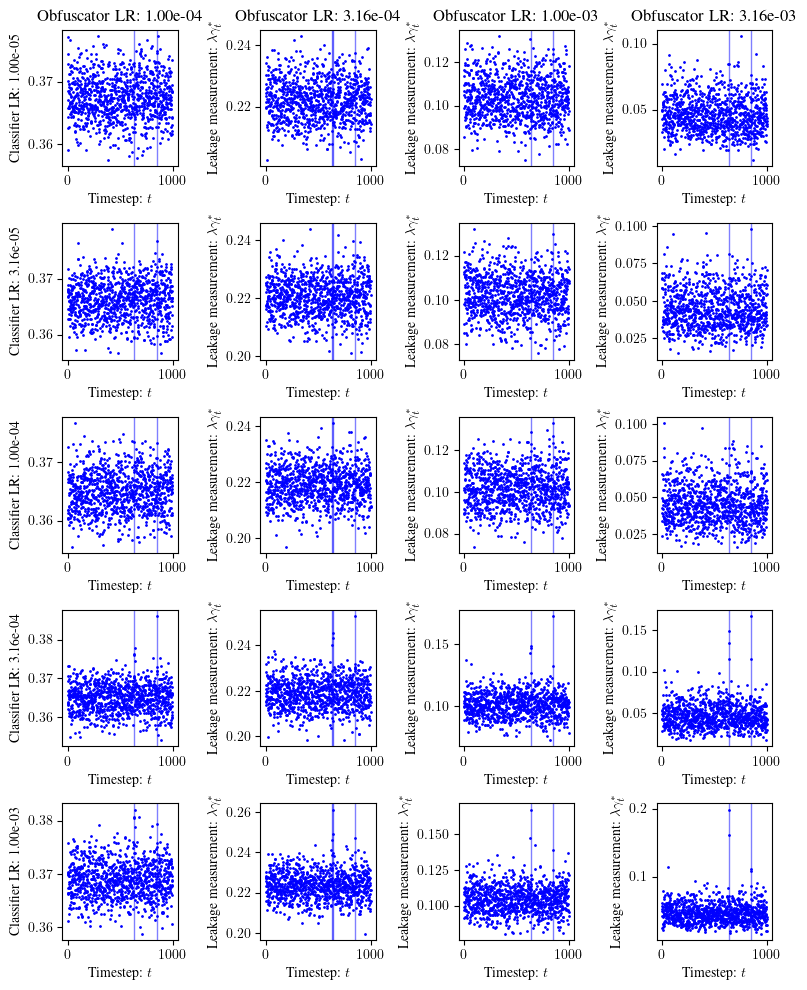

In [19]:
fig, axes = plt.subplots(len(classifier_learning_rates), len(obfuscator_learning_rates), figsize=(2*len(obfuscator_learning_rates), 2*len(classifier_learning_rates)))
if len(obfuscator_learning_rates) == 1:
    axes = axes[:, np.newaxis]
for c_idx, classifier_lr in enumerate(classifier_learning_rates):
    for o_idx, obfuscator_lr in enumerate(obfuscator_learning_rates):
        for idx in range(result_count):
            if (results['classifier_learning_rates'][idx] == classifier_lr) and (results['obfuscator_learning_rates'][idx] == obfuscator_lr):
                ax = axes[c_idx, o_idx]
                for cycle in profiling_dataset.leaking_subbytes_cycles:
                    ax.axvspan(cycle, cycle+profiling_dataset.max_no_ops, color='blue', alpha=0.5, label='ground truth')
                ax.plot(results['erasure_probs'][idx], color='blue', linestyle='none', marker='.', markersize=2.0)
                ax.set_xlabel('Timestep: $t$')
                ax.set_ylabel('Leakage measurement: $\lambda \gamma_t^*$')
for ax, classifier_lr in zip(axes[:, 0], classifier_learning_rates):
    ax.set_ylabel(f'Classifier LR: {classifier_lr:.2e}')
for ax, obfuscator_lr in zip(axes[0, :], obfuscator_learning_rates):
    ax.set_title(f'Obfuscator LR: {obfuscator_lr:.2e}')
fig.tight_layout()